In [20]:
import pandas as pd
import numpy as np 
import altair as alt
from altair import datum
import geopandas as gpd
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import matplotlib.lines as mlines
import matplotlib.dates as mdates


import random


import baltic as bt


import datetime
from datetime import datetime as dt
from datetime import timedelta, datetime


import math
import time
import sys
import unicodedata

import numpy as np
from scipy.interpolate import UnivariateSpline ## used to smooth counts of lineages in each location at any given time
from scipy.interpolate import interp1d ## used to linearly interpolate between data points used in colouring polygons
from sklearn.decomposition import IncrementalPCA ## used to identify PCA1 when automatically producing a colour map
    


from Bio import Phylo

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [2]:
#making decimal date from string dates adapted from stackoverflow (thank you coding geniuses)
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction


In [3]:
def convert_format_month(number):
    date = dt.strptime(number, '%Y-%m-%d')
    date = dt.strftime(date, '%Y-%m')
    return date

In [4]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [5]:
#need to convert the decimal dates back to calendar dates 
def convert_partial_year(number):

    year = int(number)
    d = timedelta(days=(number - year)*(365 + is_leap(year)))
    day_one = dt(year,1,1)
    date = d + day_one
    date = dt.strftime(date, '%Y-%m-%d')
    return date

In [6]:
def is_leap(number):
    if number == 2024:
        leap = 1
    else:
        leap = 0
    return leap

In [7]:
def convert_format(number):
    date = dt.strptime(number, '%Y-%m-%d')
    date = date - timedelta(days=date.weekday())
    return date

In [8]:
#read in cluster information
sub_meta = pd.read_csv("../multitree_coalescent/data/la_clusters_with_metadata_01_22.tsv", sep = "\t")
sub_meta.head()

,strain,cluster,location,date,lineage
0,OP615256,1,Los Angeles County,2022-07-29,B.1
1,OP722516,2,Los Angeles County,2022-07-13,B.1
2,OP722510,3,Los Angeles County,2022-07-20,B.1
3,OP722515,4,Los Angeles County,2022-07-13,B.1
4,OP748957,5,Los Angeles County,2022-07-14,B.1


In [9]:
#format dates

sub_meta["year_month"] = sub_meta['date'].str.rsplit("-", 1).str[-0].tolist()
sub_meta["year"] = sub_meta['date'].str.rsplit("-", 0).str[-0].tolist()

#sub_meta = sub_meta[sub_meta.year_month.str.contains('XX*')==False]
sub_meta = sub_meta[sub_meta.year_month > "2022-01"]

#sub_meta['calendar_date'] = sub_meta.date.map(convert_partial_year)
sub_meta['year-week'] = sub_meta['date'].map(convert_format)
sub_meta['year-month'] = sub_meta['date'].map(convert_format_month)



In [59]:
# read in empirical mpox case data
la_mpox_cases_df = pd.read_csv("../multitree_coalescent/data/monkeypox_data.csv")
la_mpox_cases_df = la_mpox_cases_df.dropna(how = "all").dropna(axis = "columns", how = "all")
la_mpox_cases_df = la_mpox_cases_df.rename(columns= {"Unnamed: 0": "date"}); la_mpox_cases_df.head()

,date,cases
0,2022-05-19,1
1,2022-05-20,0
2,2022-05-21,0
3,2022-05-22,0
4,2022-05-23,0


In [64]:
#format dates
weekly_cases = la_mpox_cases_df.copy()
weekly_cases.date = pd.to_datetime(weekly_cases['date'])
weekly_cases = weekly_cases.set_index("date")
weekly_cases = weekly_cases.resample("W").sum()
weekly_cases = weekly_cases.reset_index()
weekly_cases["decimal_date"] =weekly_cases["date"].map(toYearFraction)

weekly_cases.head()

,date,cases,decimal_date
0,2022-05-22,1,2022.386187
1,2022-05-29,0,2022.405365
2,2022-06-05,4,2022.424543
3,2022-06-12,9,2022.443721
4,2022-06-19,18,2022.462900


In [62]:
#more date formatting 
la_mpox_cases_df.date = pd.to_datetime(la_mpox_cases_df['date'])
la_mpox_cases_df["decimal_date"] =la_mpox_cases_df.date.map(toYearFraction)


sub_meta.date = pd.to_datetime(sub_meta['date'])
sub_meta["decimal_date"] =sub_meta.date.map(toYearFraction)

sub_meta['count'] = sub_meta.groupby('date')['date'].transform('count')
sub_meta['monthly_count'] = sub_meta.groupby('year-month')['year-month'].transform('count')


In [46]:
#read in simulation data pre march 2023
sim_df = pd.read_csv("../data/results_sep13_2024.csv")#this is the data up until March 2023
sim_df["week"] = sim_df.date.str.rsplit(" ", 0).str[2].tolist()
sim_df = sim_df.dropna()
sim_df.week = pd.to_datetime(sim_df['week'])
sim_df["decimal_date"] =sim_df.week.map(toYearFraction)

## reading in microsimulation results for 2023-2024
sim_df_2023_onwards = pd.read_csv("../data/microsimulation_results/scenarios_aware.csv")
start_date = datetime(2023, 3, 4)
sim_df_2023_onwards['week_date'] = sim_df_2023_onwards['week'].apply(lambda x: (start_date + timedelta(weeks=x)).strftime('%Y-%m-%d'))
sim_df_2023_onwards.week_date = pd.to_datetime(sim_df_2023_onwards['week_date'])
sim_df_2023_onwards = sim_df_2023_onwards.dropna()
sim_original_2023 = sim_df_2023_onwards[["week_date", "To.Aware_S0"]]

## merging the model results
combined_sim_df = pd.merge(sim_df,sim_original_2023, left_on = "week", right_on = "week_date", how = "left" )
combined_sim_df.loc[combined_sim_df['week'] > "2023-02-28", 'Model (FoI=1) diagnosed cases'] = combined_sim_df['To.Aware_S0']
combined_sim_df

combined_sim_df.head()

,date,Empirical # of diagnosed cases,Model (FoI=1) diagnosed cases,Model (FoI=1) incidence,Model (FoI=1) symp,Model (FoI=1) R_e,Model (FoI=1.25) diagnosed cases,Model (FoI=1.25) incidence,Model (FoI=1.25) symp,Model (FoI=1.25) R_e,Model (FoI=1.5) diagnosed cases,Model (FoI=1.5) incidence,Model (FoI=1.5) symp,Model (FoI=1.5) R_e,Model (FoI=2) diagnosed cases,Model (FoI=2) incidence,week,decimal_date,week_date,To.Aware_S0
0,7/10/22 - 7/16/22,125,123,140,279,2.320441989,123,140,279,2.320442,123,140,279,2.320442,123,140,2022-07-16,2022.536872,NaT,NaN
1,7/17/22 - 7/23/22,185,179,249,392,2.677419355,179,249,392,2.677419,179,249,392,2.677419,179,249,2022-07-23,2022.556050,NaT,NaN
2,7/24/22 - 7/30/22,221,202,302,495,2.31122449,202,302,495,2.311224,202,302,495,2.311224,202,302,2022-07-30,2022.575228,NaT,NaN
3,7/31/22 - 8/6/22,264,226,391,619,2.36969697,226,391,619,2.369697,226,391,619,2.369697,226,391,2022-08-06,2022.594406,NaT,NaN
4,8/7/22 - 8/13/22,261,258,143,645,0.693053312,258,143,645,0.693053,258,143,645,0.693053,258,143,2022-08-13,2022.613584,NaT,NaN


In [67]:
## read in LADPH vaccination data
mpox_vax_df = pd.read_csv("../data/mpox_vax_by_dose.csv")
mpox_vax_df["Week "] = pd.to_datetime(mpox_vax_df['Week '])
mpox_vax_df["decimal_date"] =mpox_vax_df["Week "].map(toYearFraction)
mpox_vax_df.head()


,Week,1st doses,2nd doses,decimal_date
0,2022-05-22,0,0,2022.386187
1,2022-05-29,0,0,2022.405365
2,2022-06-05,42,0,2022.424543
3,2022-06-12,8,0,2022.443721
4,2022-06-19,34,0,2022.462900


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_36676/1836234498.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario_intro_long.variable[scenario_intro_long.variable == "To.Aware_S8"] = "5"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_36676/1836234498.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario_intro_long.variable[scenario_intro_long.variable == "To.Aware_S9"] = "10"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_36676/1836234498.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

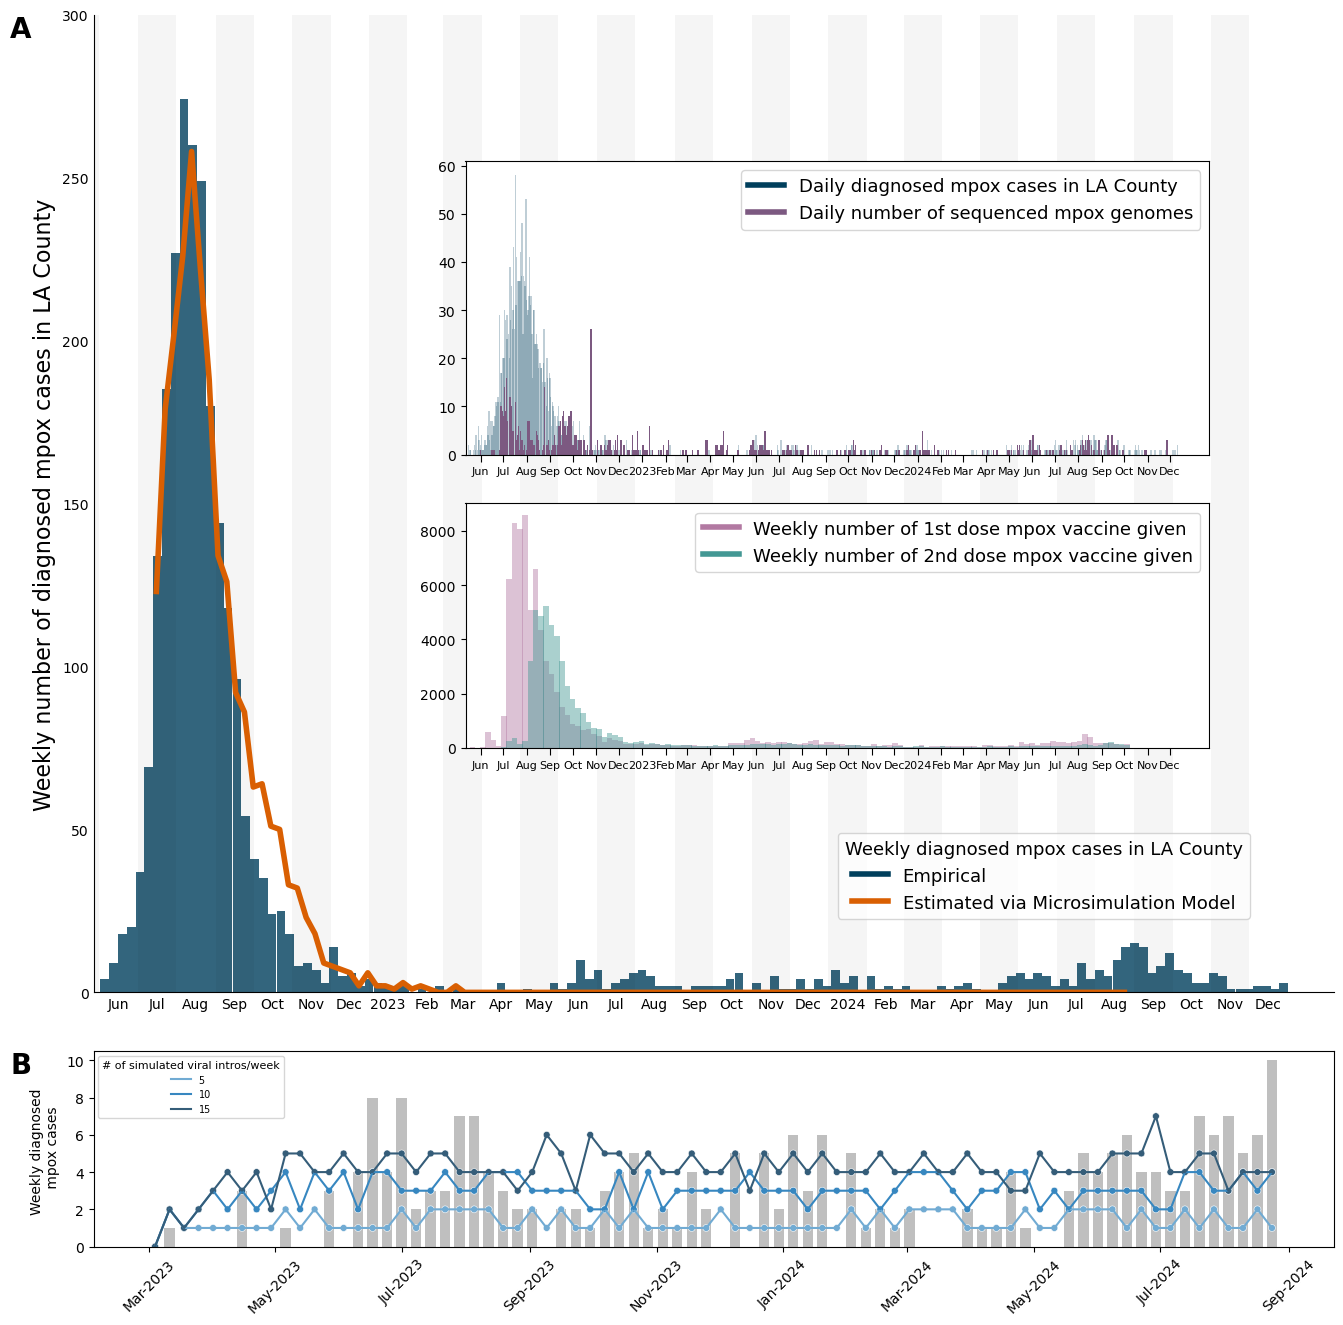

In [66]:
fig = plt.figure(figsize=(16,16),facecolor='w')


#gs = GridSpec(2, 2, height_ratios=[6, 1], width_ratios=[0.25, 1], hspace=0.1)  
gs = GridSpec(2, 1, height_ratios=[5, 1], hspace=0.1)  # Two rows, one column

# Add the first subplot (main plot)
ax1 = fig.add_subplot(gs[0])

#set the two inset plots for genomes and vaccines
ins_ax = ax1.inset_axes([.3, .55, .6, .3])  # [x, y, width, height] w.r.t. ax
ins_ax2 = ax1.inset_axes([.3, .25, .6, .25])  # [x, y, width, height] w.r.t. ax

    
# set blank white face for background    
ax1.set_facecolor('white')
# remove grid 
ax1.grid(False)

#plot the main figure with weekly cases
ax1.bar(weekly_cases.decimal_date, weekly_cases["cases"], color="#003f5c", alpha = 0.8, width = 0.019)
ax1.plot(combined_sim_df.decimal_date, combined_sim_df["Model (FoI=1) diagnosed cases"], color="#d95f02", linewidth = 4, )

# # set ylabel
ax1.set_ylabel('Weekly number of diagnosed mpox cases in LA County', fontsize=16)

# add panel label
ax1.text(-0.05, 1, "A", transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')  


#plot the number of genomes per day
ins_ax.bar(la_mpox_cases_df.decimal_date,  la_mpox_cases_df.cases, color="#003f5c", alpha = 0.25, width = 0.005)
ins_ax.bar(sub_meta.decimal_date, sub_meta["count"], color="#7c5981", width = 0.005)

#plot the number of vaccines per week
ins_ax2.bar(mpox_vax_df.decimal_date,  mpox_vax_df["1st doses"], color="#b279a2", alpha = 0.45, width = 0.02)
ins_ax2.bar(mpox_vax_df.decimal_date, mpox_vax_df["2nd doses"], color="#439894", alpha = 0.45, width = 0.02)


#format legends
legend_list = [mlines.Line2D([0], [0], color="#003f5c", lw=4, label='Empirical'),
                mlines.Line2D([0], [0], color="#d95f02", lw=4, label='Estimated via Microsimulation Model'),]
ax1.legend(handles=legend_list, title='Weekly diagnosed mpox cases in LA County', fontsize=13, title_fontsize=13, loc = [0.6,0.075])

legend_list_inset = [mlines.Line2D([0], [0], color="#003f5c", lw=4, label='Daily diagnosed mpox cases in LA County'),
                mlines.Line2D([0], [0], color="#7c5981", lw=4, label='Daily number of sequenced mpox genomes'),]
ins_ax.legend(handles=legend_list_inset, title='', fontsize=13, title_fontsize=13, loc = "upper right")

legend_list_inset = [mlines.Line2D([0], [0], color="#b279a2", lw=4, label='Weekly number of 1st dose mpox vaccine given'),
                mlines.Line2D([0], [0], color="#439894", lw=4, label='Weekly number of 2nd dose mpox vaccine given'),]
ins_ax2.legend(handles=legend_list_inset, title='', fontsize=13, title_fontsize=13, loc = "upper right")


# Add the second subplot for importation analysis directly below
ax2 = fig.add_subplot(gs[1]) 
## reading in scenario importation analysis 
modeling_df = sim_df_2023_onwards.rename(columns = {"week_date": "date"})
empirical_cases = pd.read_csv("../data/results_sep13_2024.csv") #currently the empircial cases are in a different file, need to update that

##format dates and remove NA due to the excel to csv conversion
empirical_cases["date"] = empirical_cases.date.str.rsplit(" ", 0).str[2].tolist()
empirical_cases = empirical_cases.dropna()
empirical_cases.date = pd.to_datetime(empirical_cases['date'])
empirical_cases= empirical_cases[["date", "Empirical # of diagnosed cases"]]

#go from wide to long format for easier plotting
scenario_intro_long = pd.melt(modeling_df, id_vars='date', value_vars=['To.Aware_S8', 'To.Aware_S9', 'To.Aware_S10'])
scenario_intro_long.date = pd.to_datetime(scenario_intro_long.date)

#change names for easier plotting
scenario_intro_long.variable[scenario_intro_long.variable == "To.Aware_S8"] = "5"
scenario_intro_long.variable[scenario_intro_long.variable == "To.Aware_S9"] = "10"
scenario_intro_long.variable[scenario_intro_long.variable == "To.Aware_S10"] = "15"


#first plot the empirical cases as bar chart
ax2.bar(empirical_cases.date[empirical_cases.date > "2023-03-01"] ,empirical_cases["Empirical # of diagnosed cases"][empirical_cases.date > "2023-03-01"], color = "gray", alpha = 0.5, width = 5)

#now plot lines and points of scenario analysis
sns.lineplot(
    data=scenario_intro_long,
    x='date',
    y='value',
    hue='variable',
    palette='Blues_d',
    legend='full', 
    ax = ax2
)

sns.scatterplot(
    data=scenario_intro_long,
    x='date',
    y='value',
    hue = "variable",
    palette = "Blues_d",
    s=25,  # Adjust point size
    marker='o', 
    legend = None, 
    ax = ax2
)


plt.xticks(rotation=45)

ax2.legend(title="# of simulated viral intros/week", fontsize=7, title_fontsize=8, loc = "upper left")

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# Set axis labels
ax2.set_ylabel('Weekly diagnosed \n mpox cases')
ax2.set_xlabel("")
#ax.set_ylim(0, 0.10)  # Y-axis limits
ax2.text(-0.05, 1, "B", transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')  




#work on making the vertical gray bars for ease of interpretation
xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]
xDates2=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]


every=1
[ax1.axvspan(bt.decimalDate(xDates2[x]),bt.decimalDate(xDates2[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates2),2)]
ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax1.tick_params(axis='x',labelsize=10,size=0)  

# make sure the x axes match for the insets as well
ins_ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ins_ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ins_ax.tick_params(axis='x',labelsize=8,size=5)  

ins_ax2.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ins_ax2.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ins_ax2.tick_params(axis='x',labelsize=8,size=5)  

#ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()

[ax1.spines[loc].set_visible(False) for loc in ['top','right']]

ax1.tick_params(axis='y',size=0)
#ax.set_yticklabels([])
ax1.set_ylim(0,300)
ax1.set_xlim(2022.4,2025.1)
ins_ax.set_xlim(2022.4,2025.1)
ins_ax2.set_xlim(2022.4,2025.1)



ax1.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
ax1.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)
plt.savefig('../figures/descriptive_epi.png',dpi=300,bbox_inches='tight')


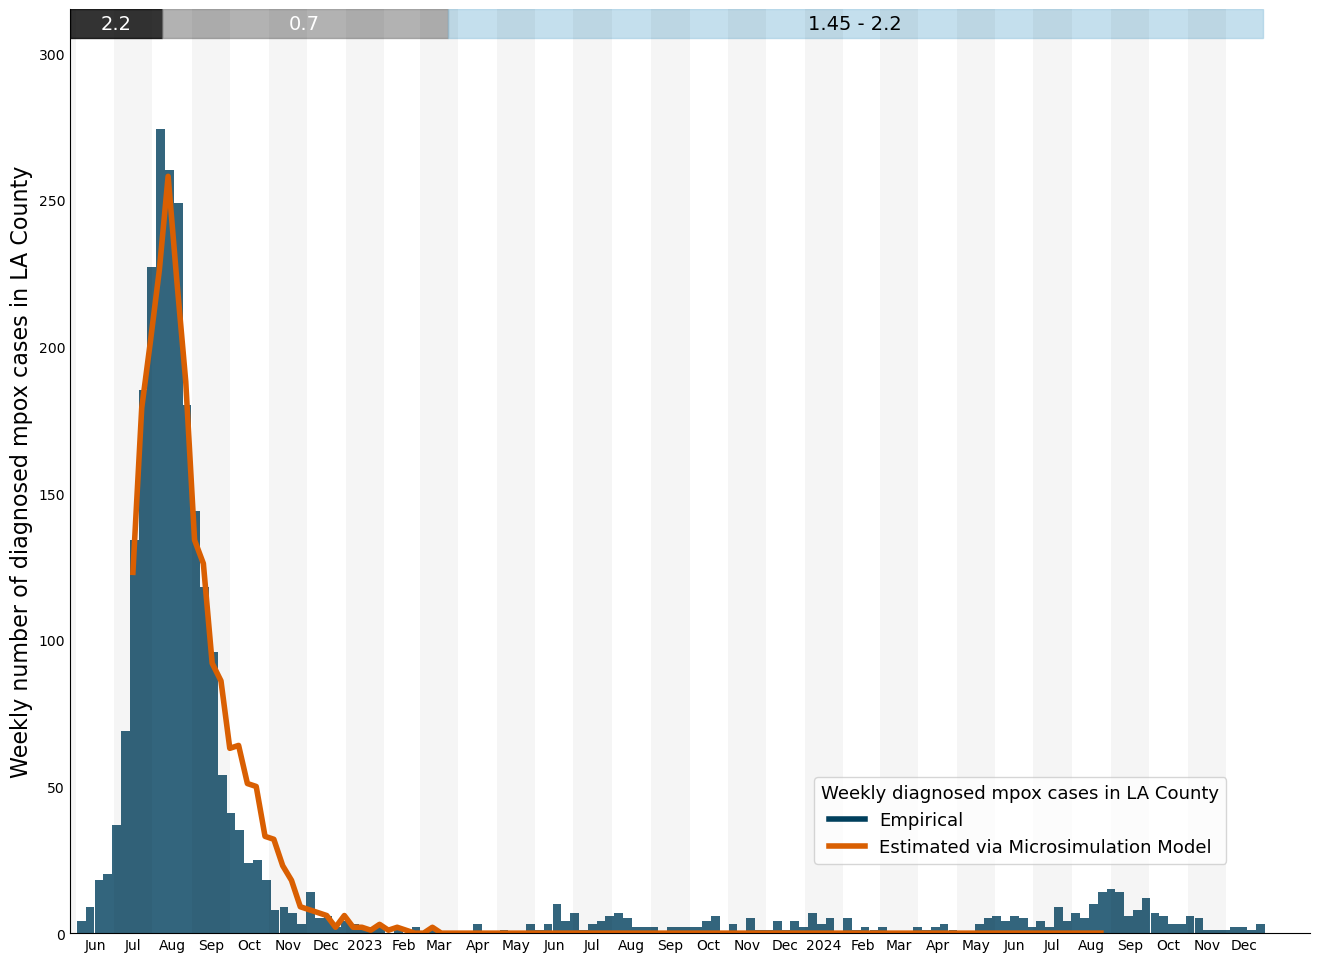

In [80]:
fig,ax = plt.subplots(figsize=(16,12),facecolor='w')

# ins_ax = ax.inset_axes([.3, .55, .6, .3])  # [x, y, width, height] w.r.t. ax
# ins_ax2 = ax.inset_axes([.3, .25, .6, .25])  # [x, y, width, height] w.r.t. ax

    
# set blank white face for background    
ax.set_facecolor('white')
# remove grid 
ax.grid(False)

## first plot the main graph with the weekly number of diagnosed cases -- both empirical and modelled 

ax.bar(weekly_cases.decimal_date, weekly_cases["cases"], color="#003f5c", alpha = 0.8, width = 0.019)
ax.plot(combined_sim_df.decimal_date, combined_sim_df["Model (FoI=1) diagnosed cases"], color="#d95f02", linewidth = 4, )


# set ylabel
ax.set_ylabel('Weekly number of diagnosed mpox cases in LA County', fontsize=16)

##set up inset plots
#first for sequences

ins_ax.bar(la_mpox_cases_df.decimal_date,  la_mpox_cases_df.cases, color="#003f5c", alpha = 0.25, width = 0.005)
ins_ax.bar(sub_meta.decimal_date, sub_meta["count"], color="#7c5981", width = 0.005)
#next for vax data

ins_ax2.bar(mpox_vax_df.decimal_date,  mpox_vax_df["1st doses"], color="#b279a2", alpha = 0.45, width = 0.02)
ins_ax2.bar(mpox_vax_df.decimal_date, mpox_vax_df["2nd doses"], color="#439894", alpha = 0.45, width = 0.02)


# Adding in horizontal boxes above the figure to highlight FoI
box_base_y = 305
box_height = 10
start_date = 2022.4
mid_date = bt.decimalDate("2022-08-08")
end_date = bt.decimalDate("2023-03-23")
final_date = bt.decimalDate("2024-12-31")

ax.axhspan(box_base_y, box_base_y + box_height, xmin=(start_date - start_date) / (2025.1 - start_date), 
           xmax=(mid_date - start_date) / (2025.1 - start_date), color="black", alpha=0.8)

# Add the second box
ax.axhspan(box_base_y, box_base_y + box_height, xmin=(mid_date - start_date) / (2025.1 - start_date), 
           xmax=(end_date - start_date) / (2025.1 - start_date), color="gray", alpha=0.6)

## add the third box
ax.axhspan(box_base_y, box_base_y + box_height, xmin=(end_date - start_date) / (2025.1 - start_date), 
           xmax=(final_date - start_date) / (2025.1 - start_date), color="#9ecae1", alpha=0.6)


# add text labels above the boxes
ax.text((start_date + mid_date) / 2, box_base_y + box_height / 2, "2.2", color="white", 
        fontsize=14, ha="center", va="center")
ax.text((mid_date + end_date) / 2, box_base_y + box_height / 2, "0.7", color="white", 
        fontsize=14, ha="center", va="center")
ax.text((end_date + final_date) / 2, box_base_y + box_height / 2, "1.45 - 2.2", color="black", 
        fontsize=14, ha="center", va="center")


#format all the different legends
legend_list = [mlines.Line2D([0], [0], color="#003f5c", lw=4, label='Empirical'),
                mlines.Line2D([0], [0], color="#d95f02", lw=4, label='Estimated via Microsimulation Model'),]
ax.legend(handles=legend_list, title='Weekly diagnosed mpox cases in LA County', fontsize=13, title_fontsize=13, loc = [0.6,0.075])

legend_list_inset = [mlines.Line2D([0], [0], color="#003f5c", lw=4, label='Daily diagnosed mpox cases in LA County'),
                mlines.Line2D([0], [0], color="#7c5981", lw=4, label='Daily number of sequenced mpox genomes'),]
ins_ax.legend(handles=legend_list_inset, title='', fontsize=13, title_fontsize=13, loc = "upper right")

legend_list_inset = [mlines.Line2D([0], [0], color="#b279a2", lw=4, label='Weekly number of 1st dose mpox vaccine given'),
                mlines.Line2D([0], [0], color="#439894", lw=4, label='Weekly number of 2nd dose mpox vaccine given'),]
ins_ax2.legend(handles=legend_list_inset, title='', fontsize=13, title_fontsize=13, loc = "upper right")

## add in grey vertical lines for each month for ease of interpretation

xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]
xDates2=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]


every=1

[ax.axvspan(bt.decimalDate(xDates2[x]),bt.decimalDate(xDates2[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates2),2)]

ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=10,size=0)  

ins_ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])
ins_ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ins_ax.tick_params(axis='x',labelsize=8,size=5)  

ins_ax2.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])
ins_ax2.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ins_ax2.tick_params(axis='x',labelsize=8,size=5)  

#ax1.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right']]

ax.tick_params(axis='y',size=0)
#ax.set_yticklabels([])
ax.set_ylim(0,315)
ax.set_xlim(2022.4,2025.1)
ins_ax.set_xlim(2022.4,2025.1)
ins_ax2.set_xlim(2022.4,2025.1)


ax.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
ax.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)
#plt.savefig('../figures/descriptive_epi_foi.png',dpi=300,bbox_inches='tight')


## Estimate the percentage of cases sequenced in LA County

In [18]:
## read in incidience estimates from evofr
incidence_est = pd.read_csv("../data/case-incidence-estimates_region.tsv", sep = "\t")
incidence_est.date = pd.to_datetime(incidence_est['date'])
incidence_est = incidence_est.set_index("date")
monthly_incidence_est = incidence_est.resample("M").sum().reset_index()
monthly_incidence_est['year-month'] = monthly_incidence_est['date'].astype(str).map(convert_format_month)
monthly_incidence_est.head()

,date,median_I_smooth,I_smooth_upper_95,I_smooth_lower_95,year-month
0,2022-05-31,1.515601,1.857838,1.240536,2022-05
1,2022-06-30,104.035784,114.377841,92.114329,2022-06
2,2022-07-31,651.935970,688.964405,610.905968,2022-07
3,2022-08-31,857.888357,899.008972,816.924289,2022-08
4,2022-09-30,430.524819,458.439719,403.381277,2022-09


In [19]:
#collapse into monthly incidence counts
agg_monthly_incidence = monthly_incidence_est.groupby("year-month").agg({'median_I_smooth':'sum','I_smooth_upper_95':'sum','I_smooth_lower_95':'sum' }).reset_index()


In [20]:
#### this code snippet is used if we want to use diagnosed cases instead of estimated incidence
# la_mpox_cases_df['year-month'] = la_mpox_cases_df['date'].astype(str).map(convert_format_month)
# la_mpox_cases_df['monthly_count_cases'] = la_mpox_cases_df.groupby('year-month')['year-month'].transform('count')
# monthly_cases = la_mpox_cases_df[["year-month", "monthly_count_cases"]]
# monthly_cases = monthly_cases.drop_duplicates().reset_index()
# monthly_cases.head()


In [21]:
#collapse genomes into monthly counts
monthly_genomes = sub_meta[["year-month", "monthly_count"]]
monthly_genomes = monthly_genomes.drop_duplicates().reset_index()
monthly_genomes.head()

,index,year-month,monthly_count
0,0,2022-12,26
1,1,2022-07,134
2,3,2022-11,45
3,5,2022-09,67
4,26,2022-08,80


In [22]:
#combine all 
combined_monthly_inc_genomes = pd.merge(agg_monthly_incidence, monthly_genomes, on = "year-month" )
combined_monthly_inc_genomes.head()

,year-month,median_I_smooth,I_smooth_upper_95,I_smooth_lower_95,index,monthly_count
0,2022-06,104.035784,114.377841,92.114329,366,1
1,2022-07,651.935970,688.964405,610.905968,1,134
2,2022-08,857.888357,899.008972,816.924289,26,80
3,2022-09,430.524819,458.439719,403.381277,5,67
4,2022-10,145.933780,159.929238,134.001405,42,96


In [23]:
#calculate prop of cases seqs
combined_monthly_inc_genomes["genome_prop_median"] = combined_monthly_inc_genomes.monthly_count/ combined_monthly_inc_genomes.median_I_smooth
combined_monthly_inc_genomes["genome_prop_upper"] = combined_monthly_inc_genomes.monthly_count/ combined_monthly_inc_genomes.I_smooth_upper_95
combined_monthly_inc_genomes["genome_prop_lower"] = combined_monthly_inc_genomes.monthly_count/ combined_monthly_inc_genomes.I_smooth_lower_95

#put an upper bound
combined_monthly_inc_genomes["genome_prop_median"][combined_monthly_inc_genomes["genome_prop_median"] >1] = 1
combined_monthly_inc_genomes["genome_prop_upper"][combined_monthly_inc_genomes["genome_prop_upper"] >1] = 1
combined_monthly_inc_genomes["genome_prop_lower"][combined_monthly_inc_genomes["genome_prop_lower"] >1] = 1


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_60506/1481713774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_monthly_inc_genomes["genome_prop_median"][combined_monthly_inc_genomes["genome_prop_median"] >1] = 1
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_60506/1481713774.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_monthly_inc_genomes["genome_prop_upper"][combined_monthly_inc_genomes["genome_prop_upper"] >1] = 1
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_60506/1481713774.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl